# Comparison between cell velocity and RNA velocity

# Input & Preprocessings

In [1]:
out_dir = "output"
target_sum = 1e5
RANDOM_STATE = 0

In [2]:
import os
import glob
import itertools
import pandas as pd
from scegot import scEGOT
import numpy as np
import anndata
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import check_random_state
import matplotlib
import scvelo as scv
import adjustText
import scipy
import scipy.stats
import scanpy
from sklearn.preprocessing import MinMaxScaler

In [3]:
file_name = "../data/scRNAseq_hPGCLC_induction_Saitou.h5ad"
adata = anndata.read_h5ad(file_name)
adata

AnnData object with n_obs × n_vars = 11771 × 18922
    obs: 'sample', 'percent.mito', 'day', 'cluster_day'
    var: 'spliced', 'unspliced', 'mt', 'TF', 'gene_name'
    layers: 'X_raw', 'spliced', 'unspliced'

In [4]:
display(adata.obs)
display(adata.var)

sample  percent.mito  day cluster_day
iM.data_GTGGAAGGTCAATGGG-1    iM.data      0.056487   iM        day0
iM.data_TTCATGTCAACCCGCA-1    iM.data      0.216231   iM        day0
iM.data_GAGGGTATCCAGGACC-1    iM.data      0.076525   iM        day0
iM.data_AAGTCGTAGGCTTTCA-1    iM.data      0.080264   iM        day0
iM.data_ACCGTTCGTAACTTCG-1    iM.data      0.280788   iM        day0
...                               ...           ...  ...         ...
d2b.data_AAGCCATAGGGCGAGA-1  d2b.data      4.811476  d2b        day2
d2b.data_CAACCAATCTTCCGTG-1  d2b.data      2.554428  d2b        day2
d2b.data_AGGCCACGTGAGTAGC-1  d2b.data      3.142146  d2b        day2
d2b.data_GATCAGTTCGAGTACT-1  d2b.data      4.287140  d2b        day2
d2b.data_TCATCCGTCATGGGAG-1  d2b.data      2.835834  d2b        day2

[11771 rows x 4 columns]

spliced  unspliced  mt  TF gene_name
FAM3A           1          1   0   0     FAM3A
SLC25A1         1          1   0   0   SLC25A1
RBL1            1          1   0   0      RBL1
PPP2R1A         1          1   0   0   PPP2R1A
H3F3B           1          1   0   0     H3F3B
...           ...        ...  ..  ..       ...
OR2W5           1          0   0   0     OR2W5
ODF4            1          1   0   0      ODF4
CRP             1          0   0   0       CRP
KRTAP4-9        1          0   0   0  KRTAP4-9
THEMIS          1          1   0   0    THEMIS

[18922 rows x 5 columns]

In [5]:
marker_genes = [
    "NANOG",
    "SOX17",
    "TFAP2C",
    "PRDM1",
    "EOMES",
    "TFAP2A",
    "NKX1-2",
    "GATA3",
    "GATA4",
    "GATA6",
    "HAND1",
    "MESP1",
    "MESP2",
    "FOXA2",
    "NKX2-5",
    "FOXF1",
    "POU5F1",
    "TBXT",
    "SOX2",
    "MIXL1",
]

In [6]:
PCA_N_COMPONENTS = 150
GMM_CLUSTER_NUMBERS = [1, 2, 4, 5, 5]
DAY_NAMES = ["day0", "day0.5", "day1", "day1.5", "day2"]

# run scEGOT

In [7]:
scegot = scEGOT(
    adata,
    verbose=True,
    adata_day_key="cluster_day",
)

Processing AnnData...


In [8]:
X, pca_model = scegot.preprocess(
    pca_n_components=PCA_N_COMPONENTS,
    umi_target_sum=1e5,
    pca_random_state=RANDOM_STATE,
)

Applying RECODE...
start RECODE for scRNA-seq data
end RECODE for scRNA-seq
log: {'seq_target': 'RNA', '#significant genes': 15820, '#non-significant genes': 2582, '#silent genes': 65, 'ell': 288, 'Elapsed time': '0h 0m 20s 763ms', 'solver': 'randomized', '#test_data': 2354}
Applying UMI normalization...
Applying log1p normalization...
Applying PCA...
	sum of explained_variance_ratio = 93.66772066272378


In [9]:
gmm_models, gmm_labels = scegot.fit_predict_gmm(
    n_components_list=GMM_CLUSTER_NUMBERS,
    random_state=RANDOM_STATE,
)

Fitting GMM models with each day's data and predicting labels for them...


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


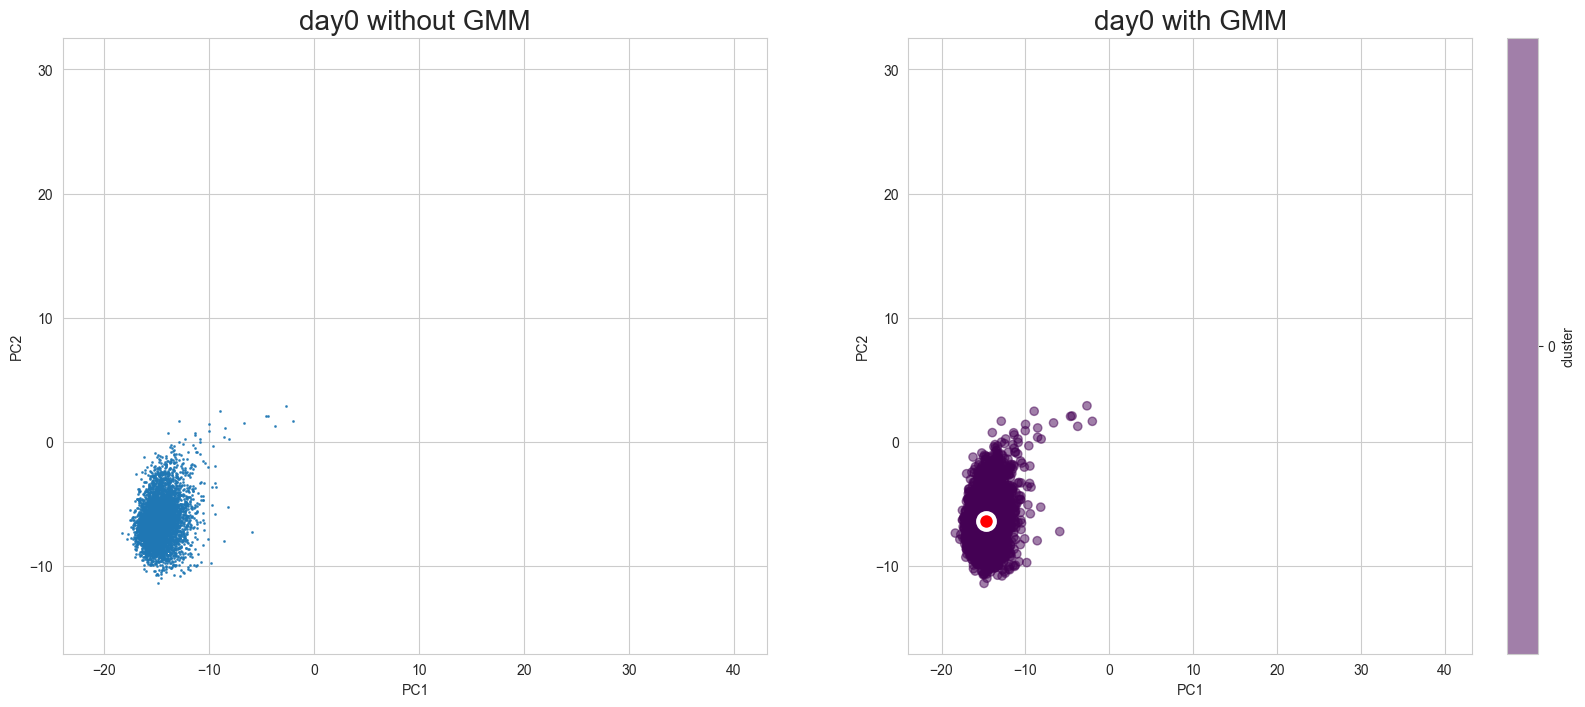

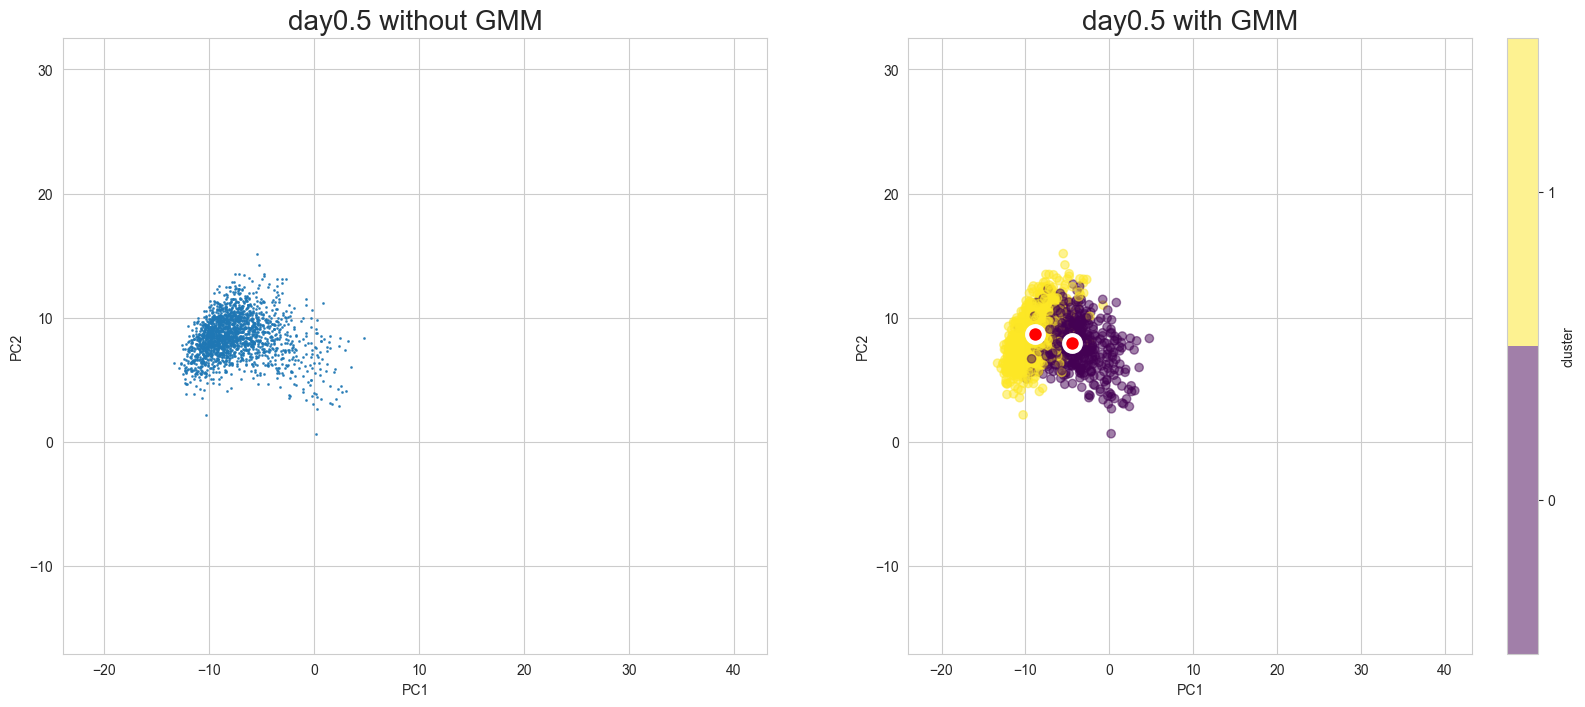

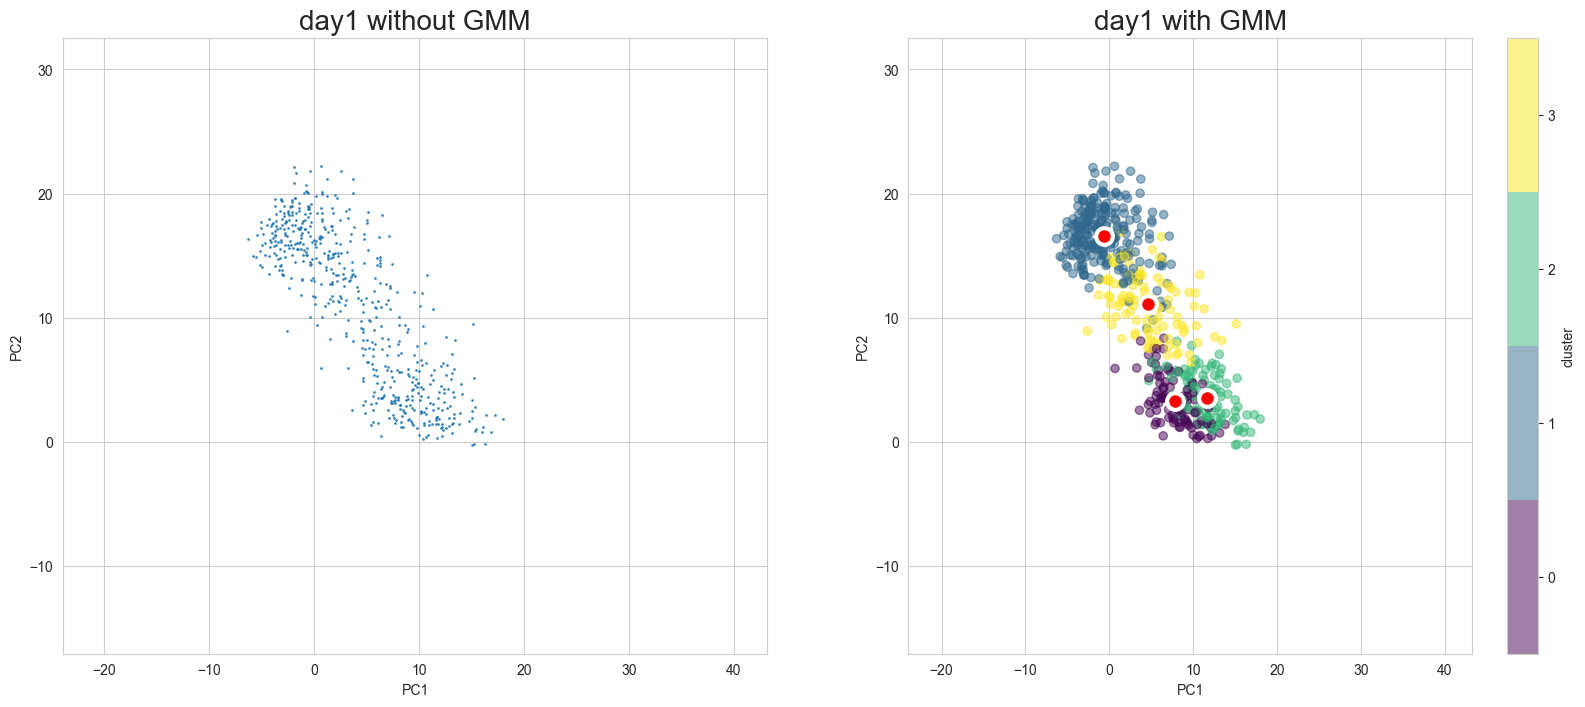

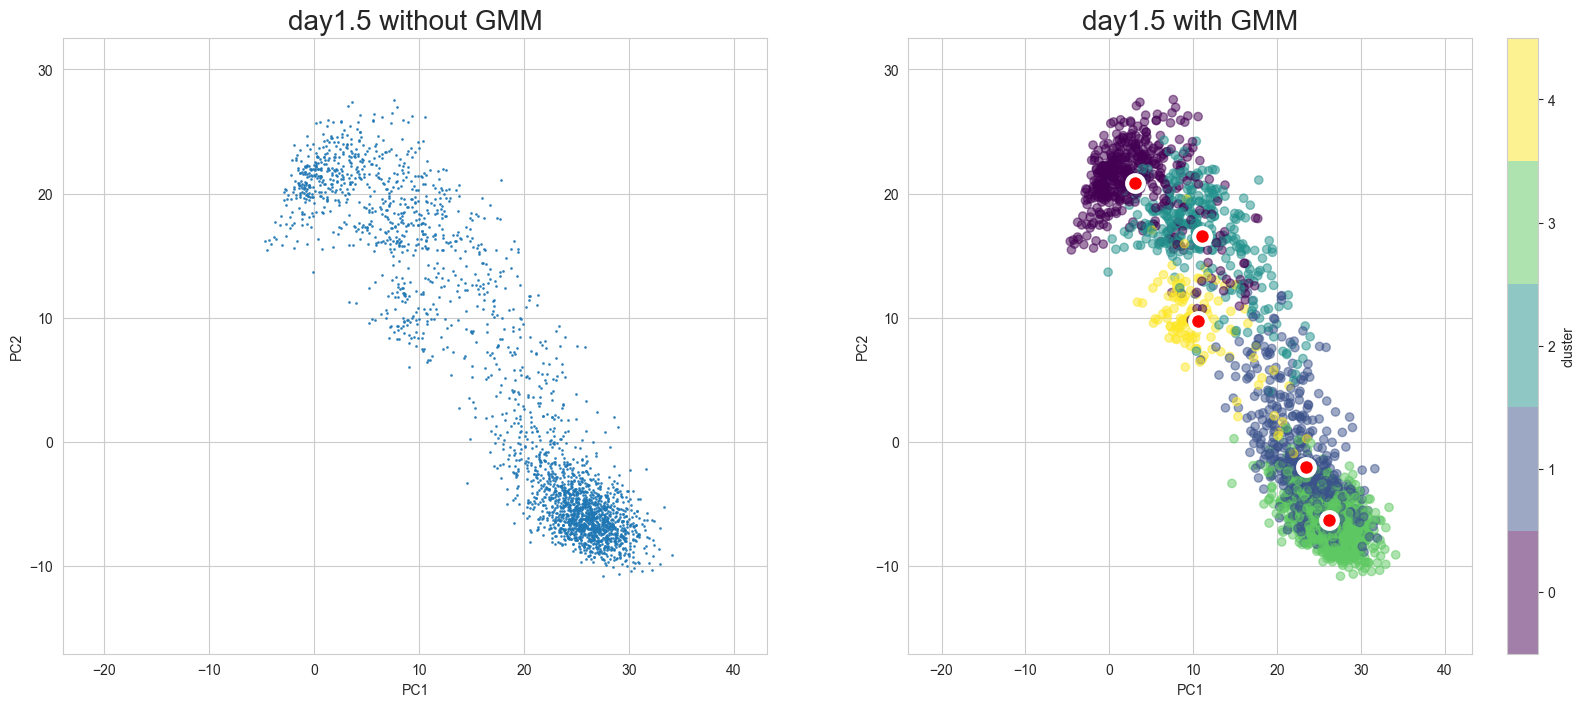

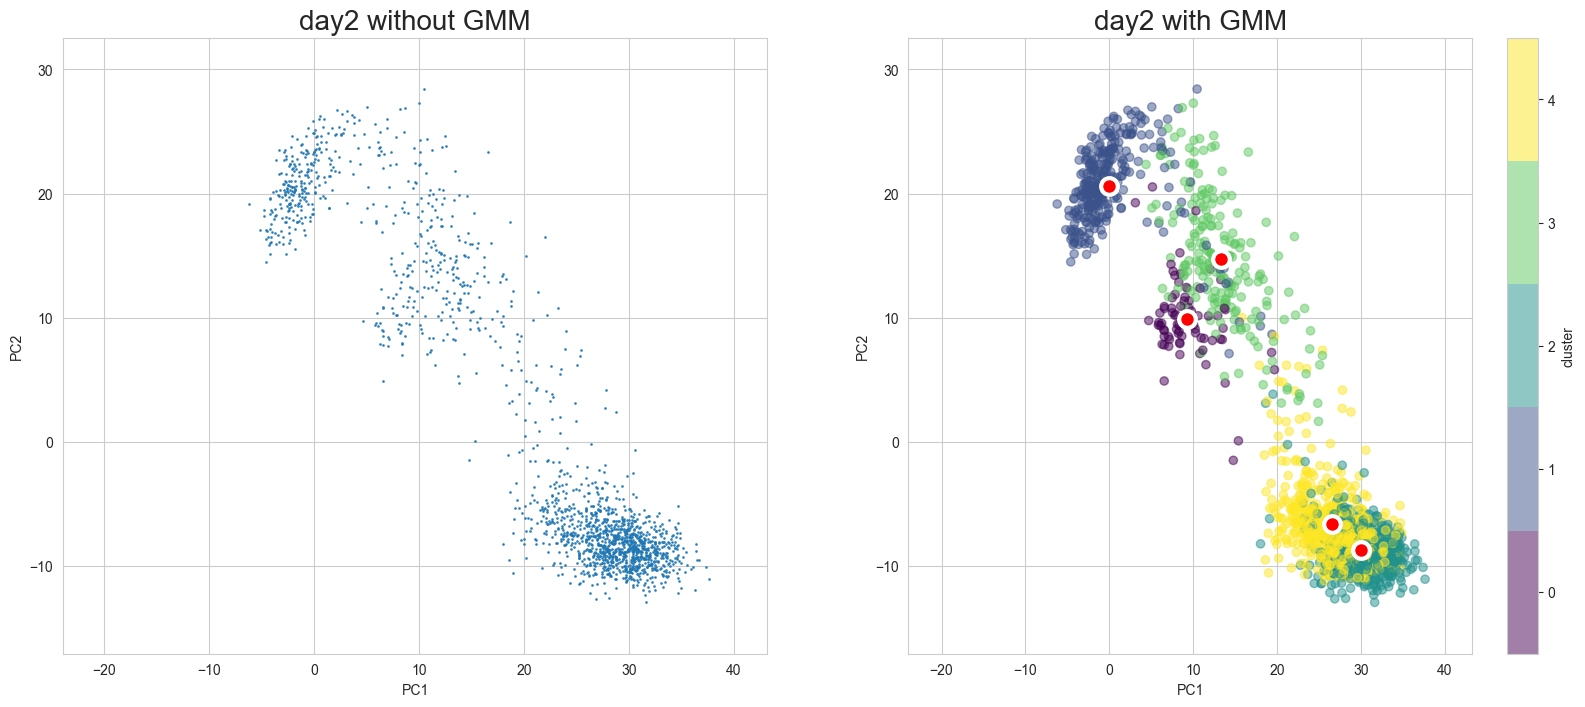

In [10]:
scegot.plot_gmm_predictions(
    mode="pca",
    plot_gmm_means=True,
    figure_titles_without_gmm=[f"{name} without GMM" for name in DAY_NAMES],
    figure_titles_with_gmm=[f"{name} with GMM" for name in DAY_NAMES],
    cmap="viridis",
    save=False,
)

## Sort clusters

In [11]:
gmm_labels_convert = [
    [0],
    [1, 0],
    [2, 0, 3, 1],
    [0, 3, 1, 4, 2],
    [2, 0, 4, 1, 3],
]
scegot.replace_gmm_labels(gmm_labels_convert)

# GMM

### FigS GM dist on PCA

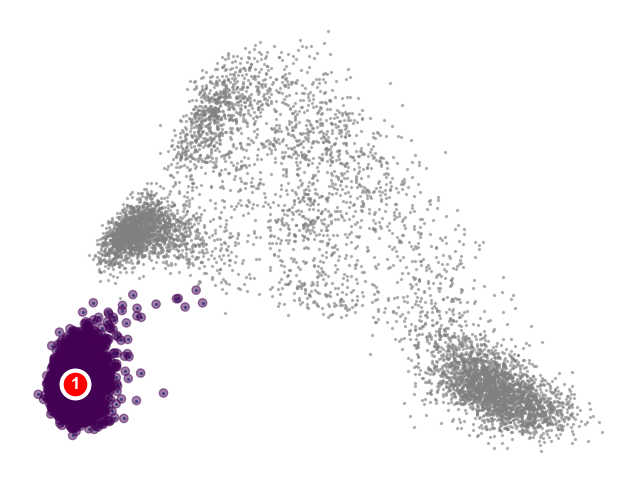

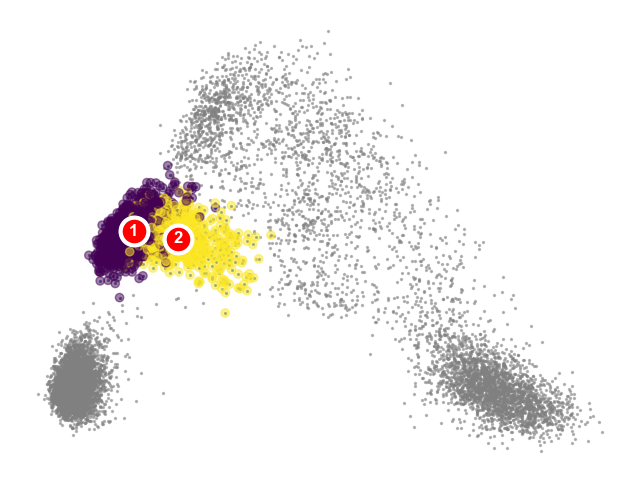

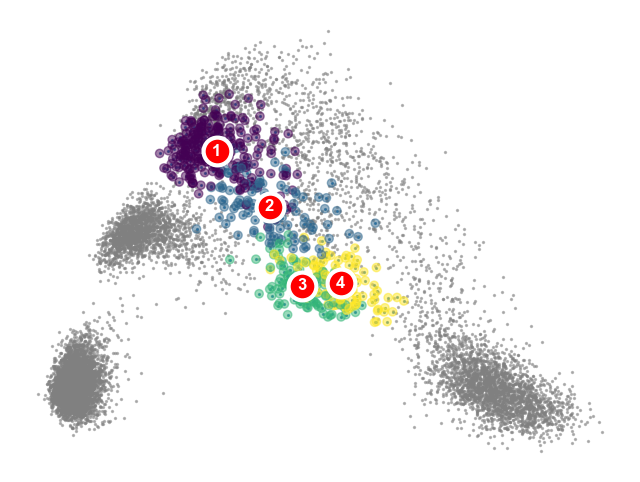

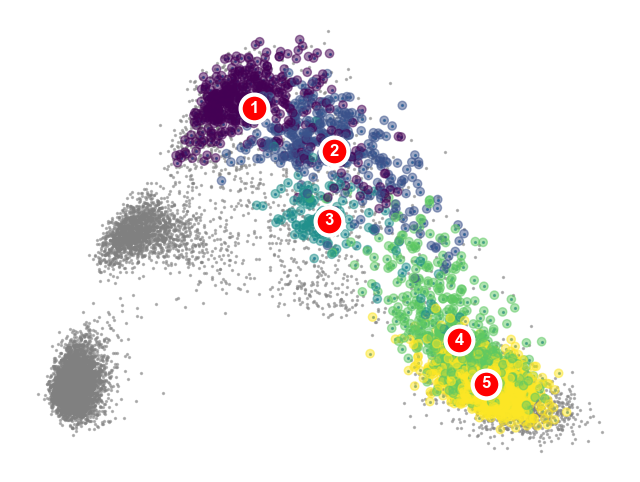

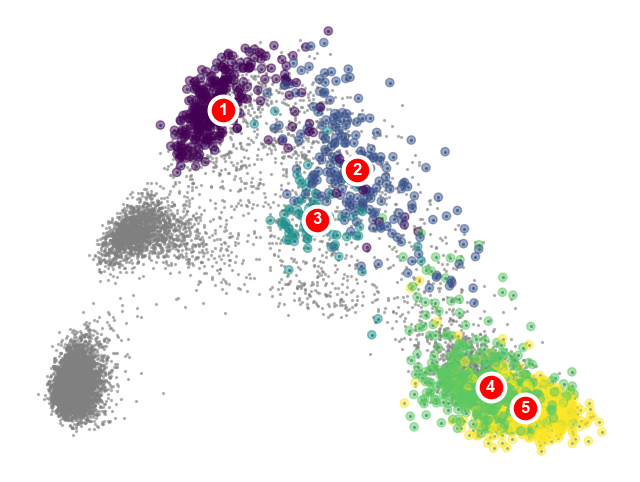

In [12]:
figure_labels = None
plot_gmm_means = False
plot_gmm_means = True
cmap = "viridis"
save = True
DAY_LIST_WITH_DECIMAL_POINT = ["0", "0.5", "1", "1.5", "2"]
FIGURE_NAMES_BY_DAY = [f"Day{day}" for day in DAY_LIST_WITH_DECIMAL_POINT]
save_paths = [f"./{out_dir}/Fig_GMM_PCA_{name}.png" for name in FIGURE_NAMES_BY_DAY]


if save and save_paths is None:
    save_paths = [f"./GMM_preds_{i + 1}.png" for i in range(len(X))]

X_all = pd.concat(X).values
i = 0
for i in range(len(X)):
    plt.figure(figsize=(8, 6))
    plt.scatter(X_all[:, 0], X_all[:, 1], color="gray", zorder=0, alpha=0.5, s=2)

    scegot._plot_gmm_predictions(X[i], plt.xlim(), plt.ylim(), figure_labels)

    gmm_model = gmm_models[i]
    X_item = X[i]

    if plot_gmm_means:
        for k in range(scegot.gmm_n_components_list[i]):
            plt.plot(
                gmm_model.means_[k][0],
                gmm_model.means_[k][1],
                "ro",
                markersize=20,
                markeredgewidth=3,
                markeredgecolor="white",
            )

    for k in range(scegot.gmm_n_components_list[i]):
        plt.text(
            gmm_model.means_[k][0],
            gmm_model.means_[k][1],
            str(gmm_labels_convert[i][k] + 1),
            color="white",
            va="center",
            ha="center",
            fontweight="bold",
            fontsize=12,
        )

    gmm_n_components = scegot.gmm_n_components_list[i]
    if gmm_labels is None:
        plt.scatter(X_item.values[:, 0], X_item.values[:, 1], s=0.5, alpha=0.5)
    else:
        plt.scatter(
            X_item.values[:, 0],
            X_item.values[:, 1],
            c=scegot.gmm_labels_modified[i],
            alpha=0.5,
            cmap=plt.cm.get_cmap(cmap, gmm_n_components),
        )

    plt.grid(False)
    plt.axis("off")

    plt.savefig(
        save_paths[i],
        dpi=200,
        bbox_inches="tight",
        transparent=True,
    )

## UMAP

In [13]:
UMAP_N_NEIGHBORS = 15
UMAP_N_COMPONENTS = 2
scegot.umap_n_components = UMAP_N_COMPONENTS
X_umap, umap_model = scegot.apply_umap(
    n_neighbors=UMAP_N_NEIGHBORS,
    random_state=RANDOM_STATE,
    min_dist=0.8,
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## FigS GM dist on UMAP

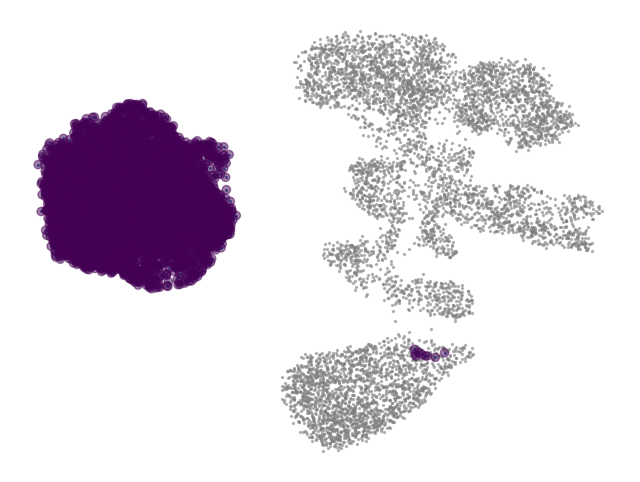

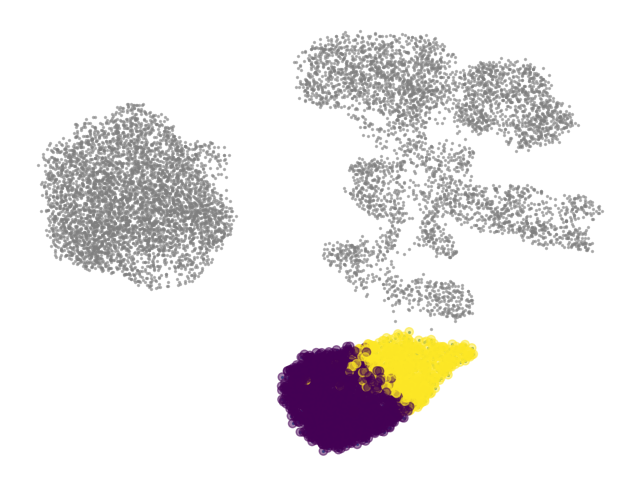

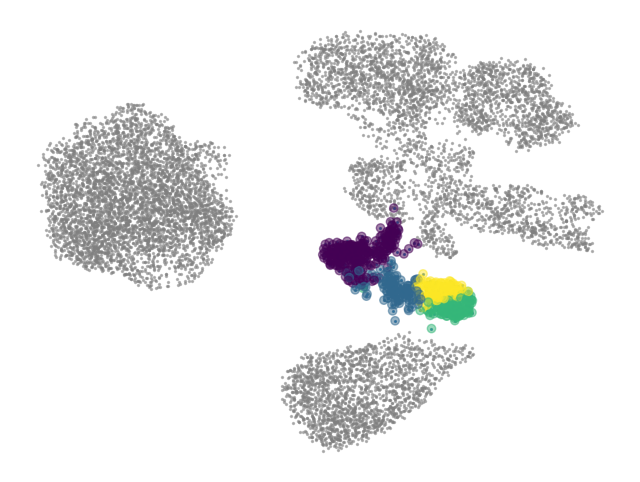

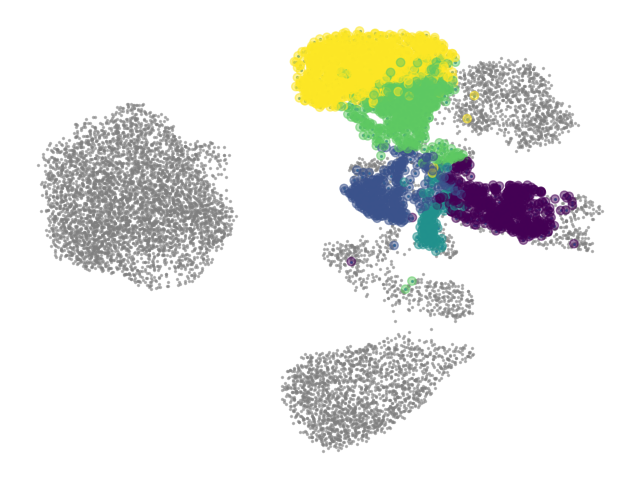

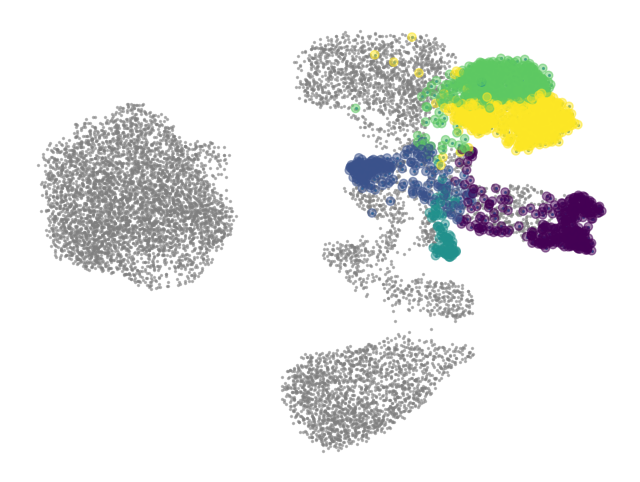

In [14]:
figure_labels = None
plot_gmm_means = False
plot_gmm_means = True
cmap = "viridis"
save = True
save_paths = [f"./{out_dir}/Fig_GMM_UMAP_{name}.png" for name in FIGURE_NAMES_BY_DAY]

X_all = pd.concat(X_umap).values
i = 0
for i in range(len(X_umap)):
    plt.figure(figsize=(8, 6))

    plt.scatter(X_all[:, 0], X_all[:, 1], color="gray", zorder=0, alpha=0.5, s=2)

    scegot._plot_gmm_predictions(X_umap[i], plt.xlim(), plt.ylim(), figure_labels)

    gmm_model = gmm_models[i]
    X_item = X_umap[i]

    gmm_n_components = scegot.gmm_n_components_list[i]
    if gmm_labels is None:
        plt.scatter(X_item.values[:, 0], X_item.values[:, 1], s=0.5, alpha=0.5)
    else:
        plt.scatter(
            X_item.values[:, 0],
            X_item.values[:, 1],
            c=scegot.gmm_labels_modified[i],
            alpha=0.5,
            cmap=plt.cm.get_cmap(cmap, gmm_n_components),
        )

    plt.grid(False)
    plt.axis("off")

    if save:
        plt.savefig(
            save_paths[i],
            dpi=200,
            bbox_inches="tight",
            transparent=True,
        )
    plt.show()

# Cluster Annotation

### Fig Days on PCA

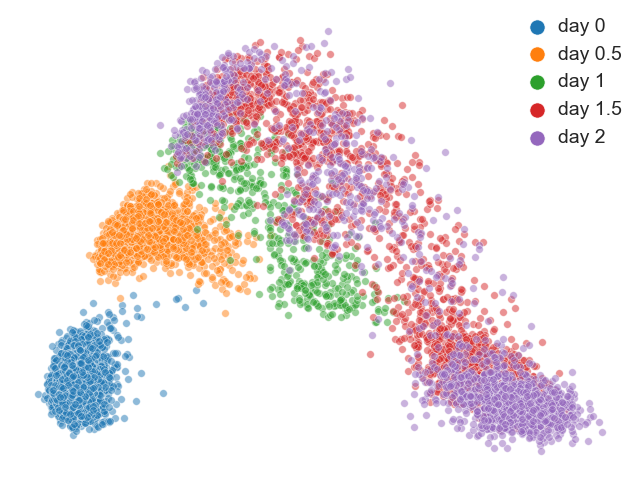

In [15]:
figsize = (8, 6)
size_pt = 30
clusters_ = adata.obs["cluster_day"]
cluster_set_ = DAY_NAMES
plot_data_ = pd.concat(X).values[:, :2]
DAY_NAMES_MOD = ["day 0", "day 0.5", "day 1", "day 1.5", "day 2"]

fig, ax = plt.subplots(figsize=figsize)
for c_ in cluster_set_:
    idx_ = clusters_ == c_
    ax.scatter(
        plot_data_[idx_, 0],
        plot_data_[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.5,
        label=DAY_NAMES_MOD[cluster_set_.index(c_)],
        edgecolors="w",
        linewidth=0.5,
    )
leg = ax.legend(
    fontsize=14,
    markerscale=2,
    borderaxespad=0,
    frameon=False,
    handletextpad=0.1,
    facecolor="w",
)
for lh in leg.legend_handles:
    lh.set_alpha(1)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_pca_days.png", bbox_inches="tight", dpi=200)

### Fig Cell types on PCA

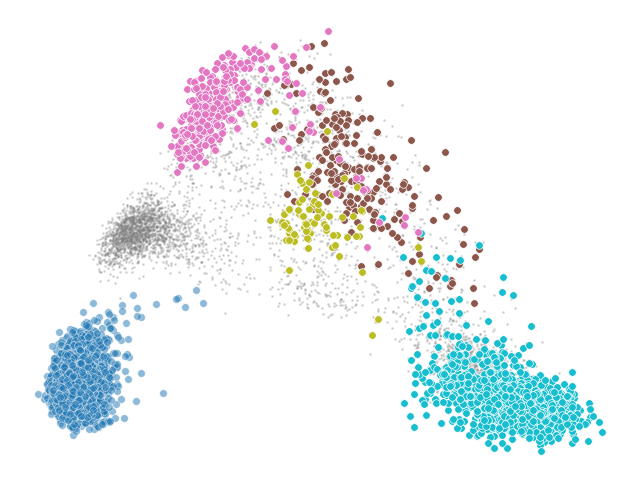

In [16]:
figsize = (8, 6)
size_pt = 30

# cluster_dict = {0: "PGCLC", 1: "ALC", 2: "ALC", 3: "ELC", 4: "LPMLC"}
cluster_dict = {0: "PGCLC", 1: "ALC", 2: "ELC", 3: "LPMLC", 4: "LPMLC"}
clusters_day2 = np.array(
    [
        cluster_dict[gmm_labels_convert[-1][gmm_labels[4][i]]]
        for i in range(len(gmm_labels[4]))
    ]
)

fig, ax = plt.subplots(figsize=figsize)
cluster_set = np.unique(clusters_day2)
data_pca = pd.concat(X[1:-1]).values[:, :2]
color_dict = {
    "ALC": "tab:brown",
    "PGCLC": "tab:pink",
    "ELC": "tab:olive",
    "LPMLC": "tab:cyan",
}
ax.scatter(data_pca[:, 0], data_pca[:, 1], color="gray", s=1, alpha=0.25)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X[-1].values[idx_, 0],
        X[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=1,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X[0].values[:, 0],
    X[0].values[:, 1],
    color=plt.cm.tab10(0),
    # facecolor=plt.cm.tab10(9),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_pca_clusters.png", bbox_inches="tight", dpi=200)

### FigS Day on UMAP

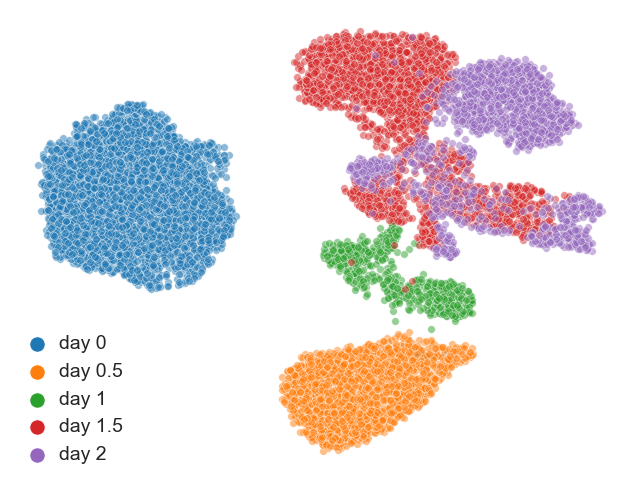

In [17]:
figsize = (8, 6)
size_pt = 30
clusters_ = adata.obs["cluster_day"]
cluster_set_ = DAY_NAMES
plot_data_ = pd.concat(X_umap).values[:, :2]

fig, ax = plt.subplots(figsize=figsize)
for c_ in cluster_set_:
    idx_ = clusters_ == c_
    ax.scatter(
        plot_data_[idx_, 0],
        plot_data_[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.5,
        label=DAY_NAMES_MOD[cluster_set_.index(c_)],
        edgecolors="w",
        linewidth=0.5,
    )
leg = ax.legend(
    fontsize=14,
    markerscale=2,
    borderaxespad=0,
    frameon=False,
    handletextpad=0.1,
    facecolor="w",
)
for lh in leg.legend_handles:
    lh.set_alpha(1)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_umap_days.png", bbox_inches="tight", dpi=200)

### FigS Cell types on UMAP

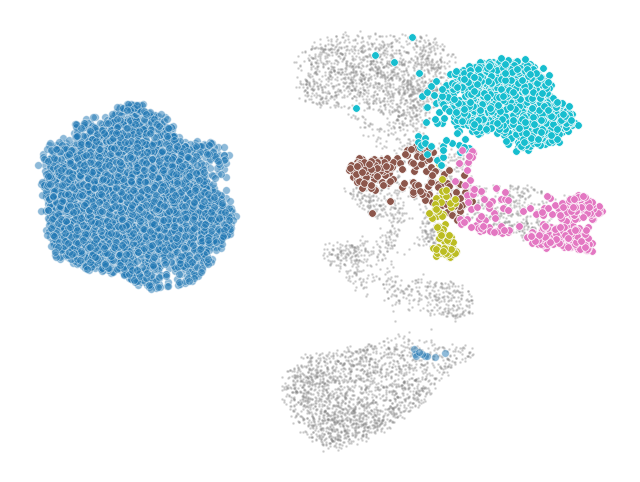

In [18]:
X_plot = X_umap
figsize = (8, 6)
size_pt = 30

fig, ax = plt.subplots(figsize=figsize)
cluster_set = np.unique(clusters_day2)
ax.scatter(
    pd.concat(X_plot[1:-1]).values[:, 0],
    pd.concat(X_plot[1:-1]).values[:, 1],
    color="gray",
    s=1,
    alpha=0.25,
)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X_plot[-1].values[idx_, 0],
        X_plot[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=1,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X_plot[0].values[:, 0],
    X_plot[0].values[:, 1],
    color=plt.cm.tab10(0),
    # facecolor=plt.cm.tab10(9),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_umap_clusters.png", bbox_inches="tight", dpi=200)

In [19]:
cluster_celltype_color = np.repeat("tab:blue", X[0].shape[0])
for i in range(3):
    cluster_celltype_color = np.append(
        cluster_celltype_color, np.repeat("tab:gray", X[i + 1].shape[0])
    )
clusters_day2_color = np.empty(clusters_day2.shape, dtype=object)
for c_ in np.unique(clusters_day2):
    clusters_day2_color[clusters_day2 == c_] = str(color_dict[c_])

cluster_celltype_color = np.append(cluster_celltype_color, clusters_day2_color)

cluster_celltype_color.shape

(11771,)

In [20]:
cluster_celltype = np.repeat(0, X[0].shape[0])
for i in range(3):
    cluster_celltype = np.append(
        cluster_celltype, np.ones(X[i + 1].shape[0], dtype=int)
    )
clusters_day2_int = np.empty(clusters_day2.shape, dtype=int)
for c_ in np.unique(clusters_day2):
    clusters_day2_int[clusters_day2 == c_] = list(set(clusters_day2)).index(c_) + 2

cluster_celltype = np.append(cluster_celltype, clusters_day2_int)

# Velocity

In [21]:
# Calculate velocities
velocities = scegot.calculate_cell_velocities()

# Calculate CellVel_genes
CellVel_genes = pca_model.inverse_transform(pd.concat(X[:-1]).values + velocities.values) - pca_model.inverse_transform(pd.concat(X[:-1]).values)

# Create day labels
day_labels = []
for i in range(len(X) - 1):
    day_labels += [i for _ in range(len(X[i]))]

# Concatenate gene expression data
X_tmp = pd.concat(X[:-1])

# Convert to numpy arrays and handle data types
velocity_values = velocities.values.astype(np.float64)
spliced_values = X_tmp.values.astype(np.float64)

# Replace NaN and Inf with zeros
velocity_values = np.nan_to_num(velocity_values)
spliced_values = np.nan_to_num(spliced_values)

# Assign gene names
var_names = [f'gene{i}' for i in range(1, spliced_values.shape[1] + 1)]

# Assign PCA data directly without transforming
X_pca = X_tmp.values  # Assuming X_tmp is already PCA-transformed with 150 components

# Concatenate UMAP data
X_umap_combined = pd.concat(X_umap[:-1]).values

# Create AnnData object
adata_cvel = anndata.AnnData(
    X=spliced_values,
    obs=pd.DataFrame(day_labels, index=X_tmp.index, columns=["clusters"]),
    var=pd.DataFrame(index=var_names),
    obsm={
        "X_pca": X_pca,  
        "X_umap": X_umap_combined,
    },
    layers={
        "velocity": velocity_values,
        "spliced": spliced_values,
    },
)

# Compute velocity graph
scv.tl.velocity_graph(adata_cvel)

Calculating cell velocities between each day...


100%|██████████| 4/4 [00:01<00:00,  2.66it/s]


or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/10 cores)


  0%|          | 0/10021 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Fig Cell velocity on PCA

computing velocity embedding
    finished (0:00:03) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


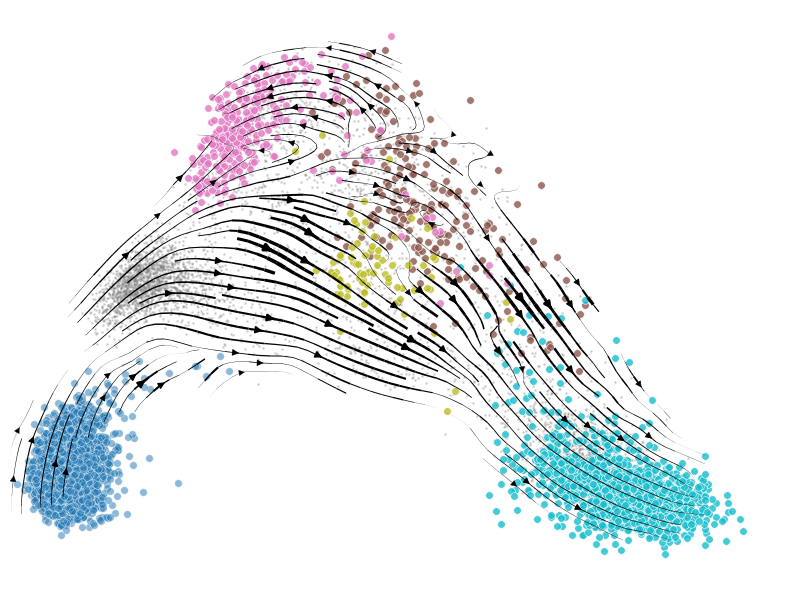

In [22]:
figsize = (8, 6)
sns.set_style("white")
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
scv.pl.velocity_embedding_stream(
    adata_cvel,
    basis="pca",
    vkey="velocity",
    color=cluster_celltype_color,
    title="",
    density=2,
    alpha=0.0,
    fontsize=14,
    legend_fontsize=0,
    legend_loc=None,
    arrow_size=1,
    linewidth=1.5,
    ax=ax,
    show=False,
    X_grid=None,
    V_grid=None,
    sort_order=True,
    size=50,
    colorbar=False,
)
size_pt = 30

clusters_day2 = np.array(
    [
        cluster_dict[gmm_labels_convert[-1][gmm_labels[4][i]]]
        for i in range(len(gmm_labels[4]))
    ]
)

cluster_set = np.unique(clusters_day2)
data_pca = pd.concat(X[1:-1]).values[:, :2]
ax.scatter(data_pca[:, 0], data_pca[:, 1], color="gray", s=1, alpha=0.25)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X[-1].values[idx_, 0],
        X[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.8,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X[0].values[:, 0],
    X[0].values[:, 1],
    color=plt.cm.tab10(0),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_Velocity_scEGOT.png", dpi=200, bbox_inches="tight")

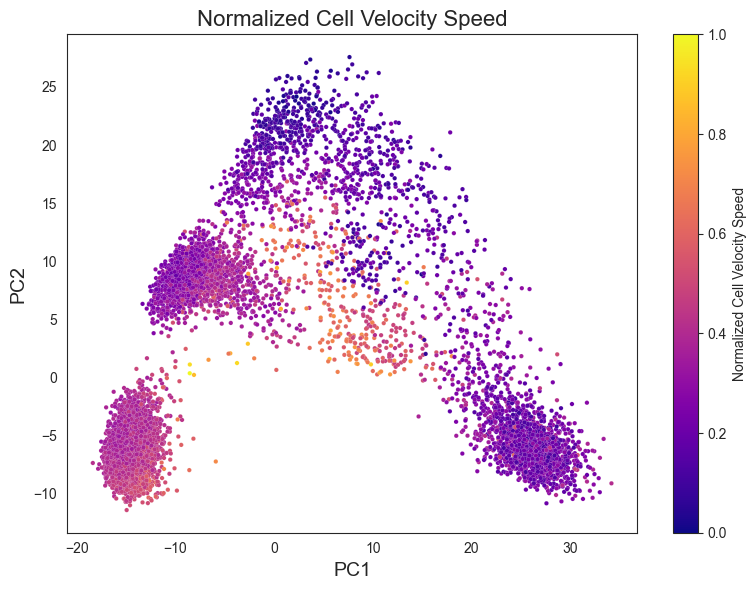

In [44]:
cell_velocity_speed = np.linalg.norm(velocities.values, axis=1)
scaler = MinMaxScaler()
cell_velocity_speed_scaled = scaler.fit_transform(cell_velocity_speed.reshape(-1, 1)).flatten()
adata_cvel.obs['velocity_speed'] = cell_velocity_speed_scaled

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
sns.set_style("white")
scatter = ax.scatter(
    adata_cvel.obsm['X_pca'][:, 0],
    adata_cvel.obsm['X_pca'][:, 1],
    c=adata_cvel.obs['velocity_speed'],
    cmap="plasma",
    s=10,
    alpha=1.0,
    edgecolors='w',
    linewidth=0.1,
    vmin=0,  
    vmax=1  
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Normalized Cell Velocity Speed')
ax.set_title('Normalized Cell Velocity Speed', fontsize=16)
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
plt.savefig("../figure/Normalized_Cell_Velocity_speed.jpeg", bbox_inches="tight", dpi=300)

## FigS Cell velocity on UMAP

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


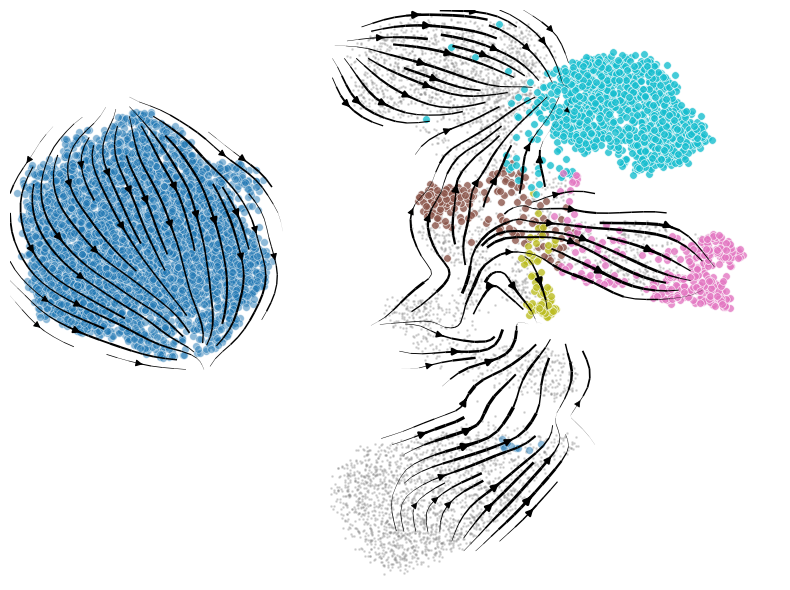

In [26]:
figsize = (8, 6)
sns.set_style("white")
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
scv.pl.velocity_embedding_stream(
    adata_cvel,
    basis="umap",
    vkey="velocity",
    color=cluster_celltype_color,
    title="",
    density=2,
    alpha=0.0,
    fontsize=14,
    legend_fontsize=0,
    legend_loc=None,
    arrow_size=1,
    linewidth=1.5,
    ax=ax,
    show=False,
    X_grid=None,
    V_grid=None,
    sort_order=True,
    size=50,
    colorbar=False,
)
size_pt = 30

clusters_day2 = np.array(
    [
        cluster_dict[gmm_labels_convert[-1][gmm_labels[4][i]]]
        for i in range(len(gmm_labels[4]))
    ]
)

cluster_set = np.unique(clusters_day2)
X_plot = X_umap
ax.scatter(
    pd.concat(X_plot[1:-1]).values[:, 0],
    pd.concat(X_plot[1:-1]).values[:, 1],
    color="gray",
    s=1,
    alpha=0.25,
)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X_plot[-1].values[idx_, 0],
        X_plot[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.8,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X_plot[0].values[:, 0],
    X_plot[0].values[:, 1],
    color=plt.cm.tab10(0),
    # facecolor=plt.cm.tab10(9),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_Velocity_scEGOT_umap.png", dpi=200, bbox_inches="tight")

## RNA velocity

In [29]:
scanpy.pp.normalize_total(adata, target_sum=target_sum)
scanpy.pp.log1p(adata)
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata, mode="stochastic")
scv.tl.velocity_graph(adata)

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead



Normalized count data: spliced, unspliced.


/opt/anaconda3/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning:

`log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.



Logarithmized X.
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:25) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1118: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



    finished (0:00:24) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/11771 [00:00<?, ?cells/s]

    finished (0:04:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dty

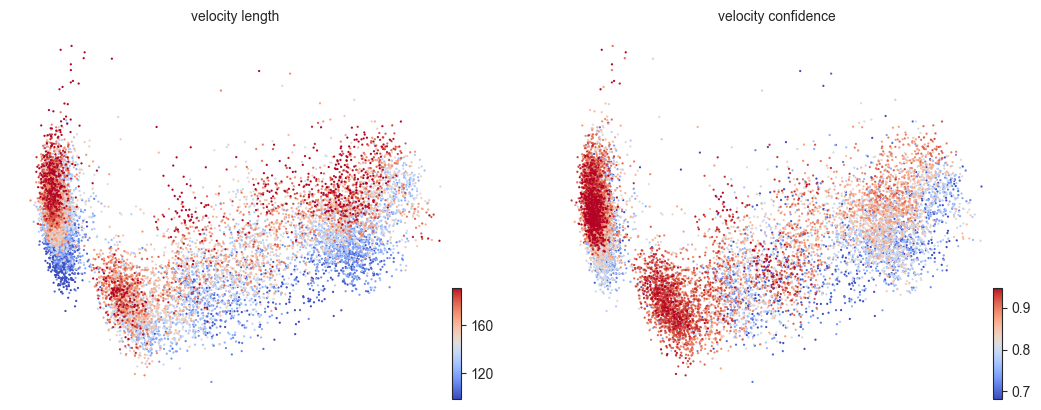

In [30]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, basis='pca', c=keys, cmap='coolwarm', perc=[5, 95])

In [ ]:
modes = "deterministic", "stochastic", "dynamical"

for mode in modes:
    print("|||||||| %s ||||||||||" % (mode))
    if mode == "dynamical":
        scv.tl.recover_dynamics(adata)
    scv.tl.velocity(adata, mode=mode, vkey="velocity_%s" % mode)
    scv.tl.velocity_graph(adata, vkey="velocity_%s" % mode)
    scv.pl.velocity_embedding_stream(adata, vkey="velocity_%s" % mode)

## Fig RNA velocity on PCA

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


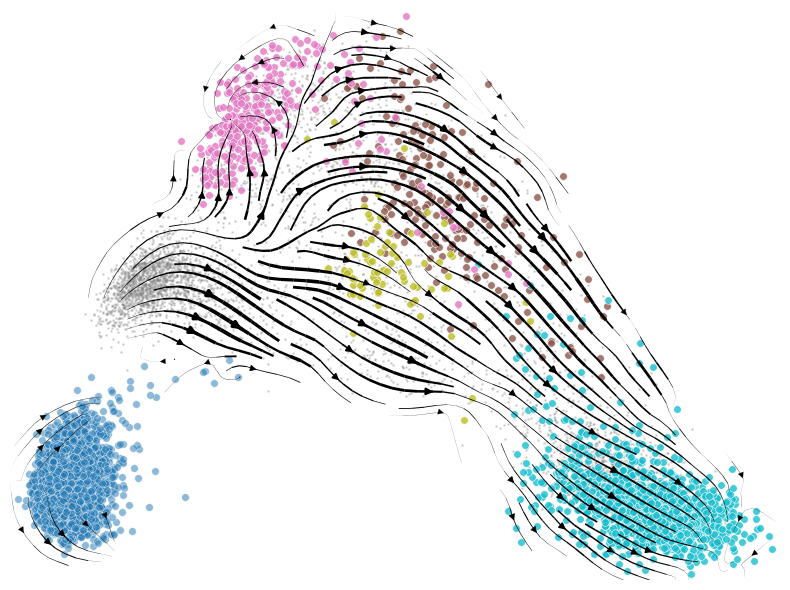

In [31]:
adata.obsm["X_pca"] = pd.concat(X).values[:, :2]

figsize = (8, 6)
sns.set_style("white")
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
scv.pl.velocity_embedding_stream(
    adata,
    basis="pca",
    vkey="velocity",
    title="",
    density=2,
    alpha=0.0,
    legend_fontsize=0,
    legend_loc=None,
    arrow_size=1,
    linewidth=1.5,
    ax=ax,
    show=False,
    size=50,
)
size_pt = 30
clusters_day2 = np.array(
    [
        cluster_dict[gmm_labels_convert[-1][gmm_labels[4][i]]]
        for i in range(len(gmm_labels[4]))
    ]
)

cluster_set = np.unique(clusters_day2)
data_pca = pd.concat(X[1:-1]).values[:, :2]
ax.scatter(data_pca[:, 0], data_pca[:, 1], color="gray", s=1, alpha=0.25)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X[-1].values[idx_, 0],
        X[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.8,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X[0].values[:, 0],
    X[0].values[:, 1],
    color=plt.cm.tab10(0),
    # facecolor=plt.cm.tab10(9),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_RNAVelocity_PCA.png", dpi=200, bbox_inches="tight")

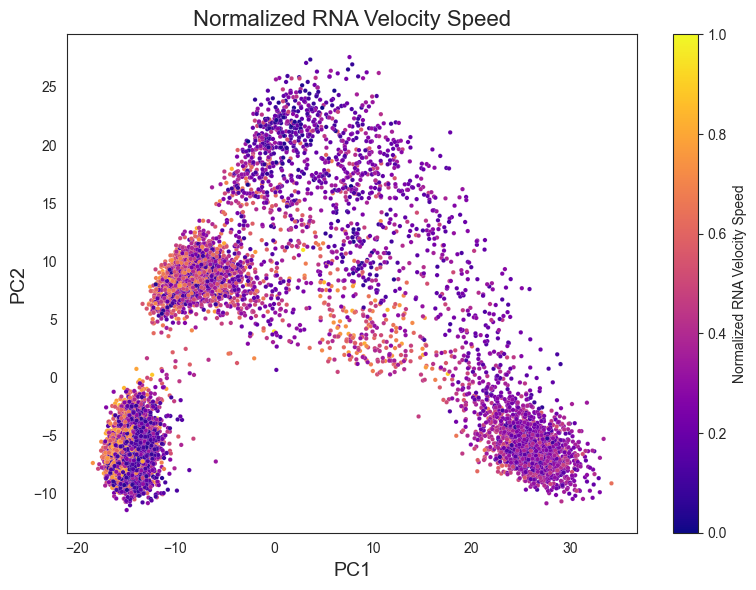

In [45]:
velocity_pca = np.dot(adata.layers['velocity'], adata.varm['PCs'][:,:2])
adata.obsm['velocity_pca'] = velocity_pca
adata.obs['velocity_length_pca'] = np.linalg.norm(adata.obsm['velocity_pca'], axis=1)
RNA_velocity_speed = adata.obs['velocity_length_pca'].values

RNA_scaler = MinMaxScaler(feature_range=(0, 1))
RNA_velocity_speed_scaled = RNA_scaler.fit_transform(RNA_velocity_speed.reshape(-1, 1)).flatten()

#plot_data = adata.obsm['X_pca'][:, :2]

target_length = len(adata_cvel.obs['velocity_speed'])
RNA_velocity_speed_scaled_adjusted = RNA_velocity_speed_scaled[:target_length]

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
sns.set_style("white")
scatter = ax.scatter(
    adata_cvel.obsm['X_pca'][:, 0],
    adata_cvel.obsm['X_pca'][:, 1],
    #c=RNA_velocity_speed_scaled,
    c=RNA_velocity_speed_scaled_adjusted,
    cmap="plasma",
    s=10,
    alpha=1.0,
    edgecolors='w',
    linewidth=0.1,
    vmin=0,  
    vmax=1  
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Normalized RNA Velocity Speed')
ax.set_title('Normalized RNA Velocity Speed', fontsize=16)
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
plt.savefig("../figure/Normalized_RNA_Velocity_Speed.jpeg", bbox_inches="tight", dpi=300)

## FigS RNA velocity on UMAP

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


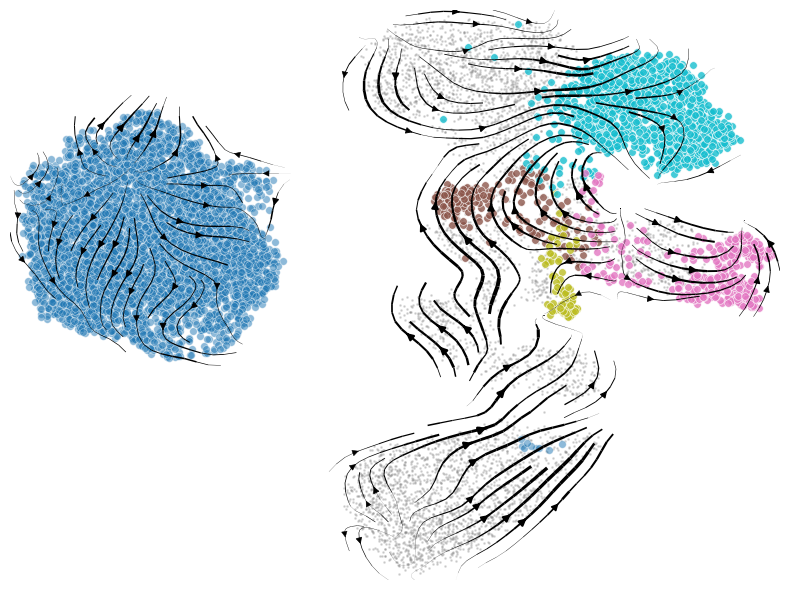

In [35]:
adata.obsm["X_umap"] = pd.concat(X_umap).values

figsize = (8, 6)
size_pt = 30

sns.set_style("white")
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)
scv.pl.velocity_embedding_stream(
    adata,
    basis="umap",
    vkey="velocity",
    title="",
    density=2,
    alpha=0.0,
    legend_fontsize=0,
    legend_loc=None,
    arrow_size=1,
    linewidth=1.5,
    ax=ax,
    show=False,
    size=50,
)

clusters_day2 = np.array(
    [
        cluster_dict[gmm_labels_convert[-1][gmm_labels[4][i]]]
        for i in range(len(gmm_labels[4]))
    ]
)

cluster_set = np.unique(clusters_day2)
X_plot = X_umap
ax.scatter(
    pd.concat(X_plot[1:-1]).values[:, 0],
    pd.concat(X_plot[1:-1]).values[:, 1],
    color="gray",
    s=1,
    alpha=0.25,
)
cmap = plt.cm.Accent
for c_ in cluster_set:
    idx_ = clusters_day2 == c_
    ax.scatter(
        X_plot[-1].values[idx_, 0],
        X_plot[-1].values[idx_, 1],
        s=size_pt,
        zorder=2,
        alpha=0.8,
        facecolor=color_dict[c_],
        edgecolors="w",
        linewidth=0.5,
    )
ax.scatter(
    X_plot[0].values[:, 0],
    X_plot[0].values[:, 1],
    color=plt.cm.tab10(0),
    # facecolor=plt.cm.tab10(9),
    edgecolors="w",
    linewidth=0.5,
    s=size_pt,
    alpha=0.5,
)
ax.axis("off")
fig.savefig(f"{out_dir}/Fig_Velocity_RNAvel_umap.png", dpi=200, bbox_inches="tight")

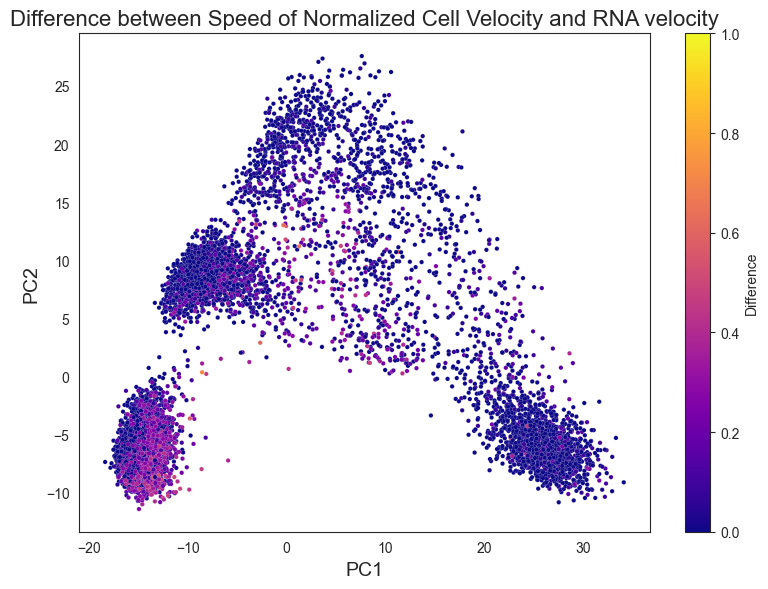

In [46]:
target_length = len(adata_cvel.obs['velocity_speed'])
RNA_velocity_speed_scaled_adjusted = RNA_velocity_speed_scaled[:target_length]
diff = adata_cvel.obs['velocity_speed'] - RNA_velocity_speed_scaled_adjusted

fig, ax = plt.subplots(figsize=(8, 6), tight_layout=True)
sns.set_style("white")
scatter = ax.scatter(
    adata_cvel.obsm['X_pca'][:, 0],
    adata_cvel.obsm['X_pca'][:, 1],
    c=diff,
    cmap="plasma",
    s=10,
    alpha=1.0,
    edgecolors='w',
    linewidth=0.1,
    vmin=0,  
    vmax=1  
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Difference')
ax.set_title('Difference between Speed of Normalized Cell Velocity and RNA velocity', fontsize=16)
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
plt.savefig("../figure/Difference.jpeg", bbox_inches="tight", dpi=300)

## PAGA velocity graph

In [37]:
#scv.tl.velocity_pseudotime(adata)
#scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot2')

In [38]:
scanpy.pp.neighbors(adata)
scanpy.tl.leiden(adata) 
scv.tl.paga(adata, groups='leiden')  

computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead

/opt/anaconda3/lib/python3.11/site-packages/scvelo/plotting/utils.py:63: DeprecationWarning:

is_categorical_dty

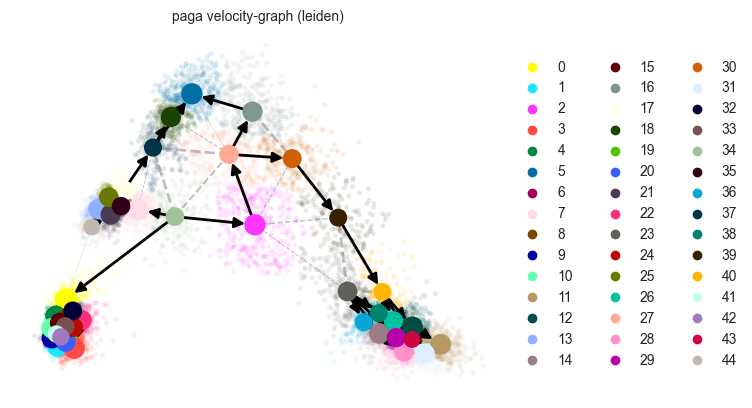

In [39]:
scv.pl.paga(adata, basis='pca', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5, show=False)
plt.savefig("../figure/PAGA_velocity_graph.jpeg", bbox_inches="tight", dpi=300)